In [73]:
import sys
sys.path.append('/Users/alexanderperalta/Library/CloudStorage/OneDrive-IndianaUniversity/G400 Capstone Final Project/Data')

In [74]:
import pandas as pd
import numpy as np
from py_modules.HistogramPlotter import HistogramPlotter
from py_modules.data_cleaner import DataCleaner

In [75]:
annual_data = pd.read_excel('Annual Financial Data (No Extra Columns).xlsx')

In [76]:
annual_data = annual_data.iloc[:, 11:]
annual_data = annual_data[annual_data['Employees'].notna()]


In [77]:
cleaner = DataCleaner(annual_data, variable_of_interest='Employees')
summary = cleaner.summarize_columns()
correlation_summary = cleaner.correlation()

correlation_summary.reset_index(inplace=True)
correlation_summary.rename(columns={'index': 'Variable'}, inplace=True)
correlation_summary = correlation_summary.dropna(subset=['Correlation with Employees'])

correlation_summary = correlation_summary.where(correlation_summary['Correlation with Employees'].abs() > 0.4).dropna()
correlation_summary = correlation_summary.where(correlation_summary['% Blank Values'] < 0.1).dropna()

highly_correlated_list = correlation_summary['Variable'].unique()

In [78]:
#correlation_summary.to_excel('Annual Data Correlations.xlsx')

In [79]:
from scipy.stats import skew

for col in annual_data.columns:
    skewness_value = skew(annual_data[col], nan_policy='omit')
    if skewness_value > 1:
        annual_data[col] = np.log1p(annual_data[col] + 1)  # Apply log transformation in place

/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1193: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: Runti

In [80]:
# Calculate quartiles
quartiles = np.quantile(annual_data['Employees'], [0, 0.25, 0.5, 0.75, 1])

# Print the quartiles
print("Minimum:", quartiles[0])
print("First Quartile:", quartiles[1])
print("Second Quartile (Median):", quartiles[2])
print("Third Quartile:", quartiles[3])
print("Maximum:", quartiles[4])

Minimum: 0.6931471805599453
First Quartile: 0.7631395523799803
Second Quartile (Median): 1.1110347951185964
Third Quartile: 1.9988752577440316
Maximum: 5.878575765029364


### **Regression Analysis - Employees**

#### **Simple Linear Regression**

In [81]:
%matplotlib inline
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [82]:
correlation_summary

,Variable,# of Blank Values,% Blank Values,# of Zeros,% Zeros,Correlation with Employees
1,Assets - Other,0.0,0.000000,585.0,0.078820,0.455483
9,Assets - Total,0.0,0.000000,10.0,0.001347,0.580069
11,Common/Ordinary Equity - Total,0.0,0.000000,0.0,0.000000,0.531892
12,Cash and Short-Term Investments,0.0,0.000000,42.0,0.005659,0.472946
13,Cash,61.0,0.008219,43.0,0.005794,0.543241
21,Cost of Goods Sold,5.0,0.000674,242.0,0.032606,0.563113
25,Long-Term Debt Due in One Year,78.0,0.010509,2073.0,0.279305,0.484566
28,Debt in Current Liabilities,0.0,0.000000,1753.0,0.236190,0.476880
29,Long-Term Debt - Total,28.0,0.003773,1763.0,0.237537,0.499977
32,"Depreciation, Depletion and Amortization (Accu...",97.0,0.013069,137.0,0.018459,0.410915


In [83]:
# Add constant term to dataset
annual_data['const'] = 1

# Create a dataframe of variables to be used in each regression
variables_to_include_reg1 = annual_data[['const',
                                'Receivables - Trade', 
                                'Liabilities and Stockholders Equity - Total', 
                                'Stock Compensation Expense']]
variables_to_include_reg2 = annual_data[['const',
                                'Receivables - Total',
                                'Sales/Turnover (Net)',
                                'Selling, General and Administrative Expenses']]
variables_to_include_reg3 = annual_data[['const',
                                'Cash',
                                'Inventories - Total',
                                'Common/Ordinary Equity - Total']]

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(annual_data['Employees'], variables_to_include_reg1, missing='drop').fit()
reg2 = sm.OLS(annual_data['Employees'], variables_to_include_reg2, missing='drop').fit()
reg3 = sm.OLS(annual_data['Employees'], variables_to_include_reg3, missing='drop').fit()

/var/folders/lj/83l4br5s2cz7n6sftfx0dy9c0000gn/T/ipykernel_32606/2357324202.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annual_data['const'] = 1


In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
# Dictionary of functions to be applied to results instances to retrieve model info
info_dict = {'F-stat': lambda x: f"{x.fvalue:.2f}",
             'F p-value': lambda x: f"{x.f_pvalue:.3f}",
             'N Obs': lambda x: f"{int(x.nobs)}",
             'SSR': lambda x: f"{x.ssr:.2f}",
             'ESS': lambda x: f"{x.ess:.2f}",
             'MSE Res': lambda x: f"{x.mse_resid:.2f}"}

#results_table = summary_col(results=[reg1,reg2,reg3],
results_table = summary_col(results=[reg1, reg2, reg3],
                            # show 2 digits
                            float_format='%0.2f',
                            stars = True,
                            # column names
                            model_names=['Model 1', 'Model 2', 'Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'Receivables - Trade', 
                                             'Stockholders Equity - Total', 
                                             'Stock Compensation Expense',
                                             'Liabilities and Stockholders Equity - Total',
                                             'Receivables - Total',
                                             'Sales/Turnover (Net)',
                                             'Selling, General and Administrative Expenses',
                                             'Cash',
                                             'Inventories - Total',
                                             'Common/Ordinary Equity - Total'])

results_table.add_title('Table: OLS Regressions')

print(results_table)

                        Table: OLS Regressions
                                             Model 1  Model 2  Model 3 
-----------------------------------------------------------------------
const                                        -0.14*** -0.11*** -0.24***
                                             (0.02)   (0.02)   (0.02)  
Receivables - Trade                          0.38***                   
                                             (0.01)                    
Stock Compensation Expense                   -0.00                     
                                             (0.01)                    
Liabilities and Stockholders Equity - Total  0.04***                   
                                             (0.01)                    
Receivables - Total                                   0.42***          
                                                      (0.01)           
Sales/Turnover (Net)                                  0.01             
                 

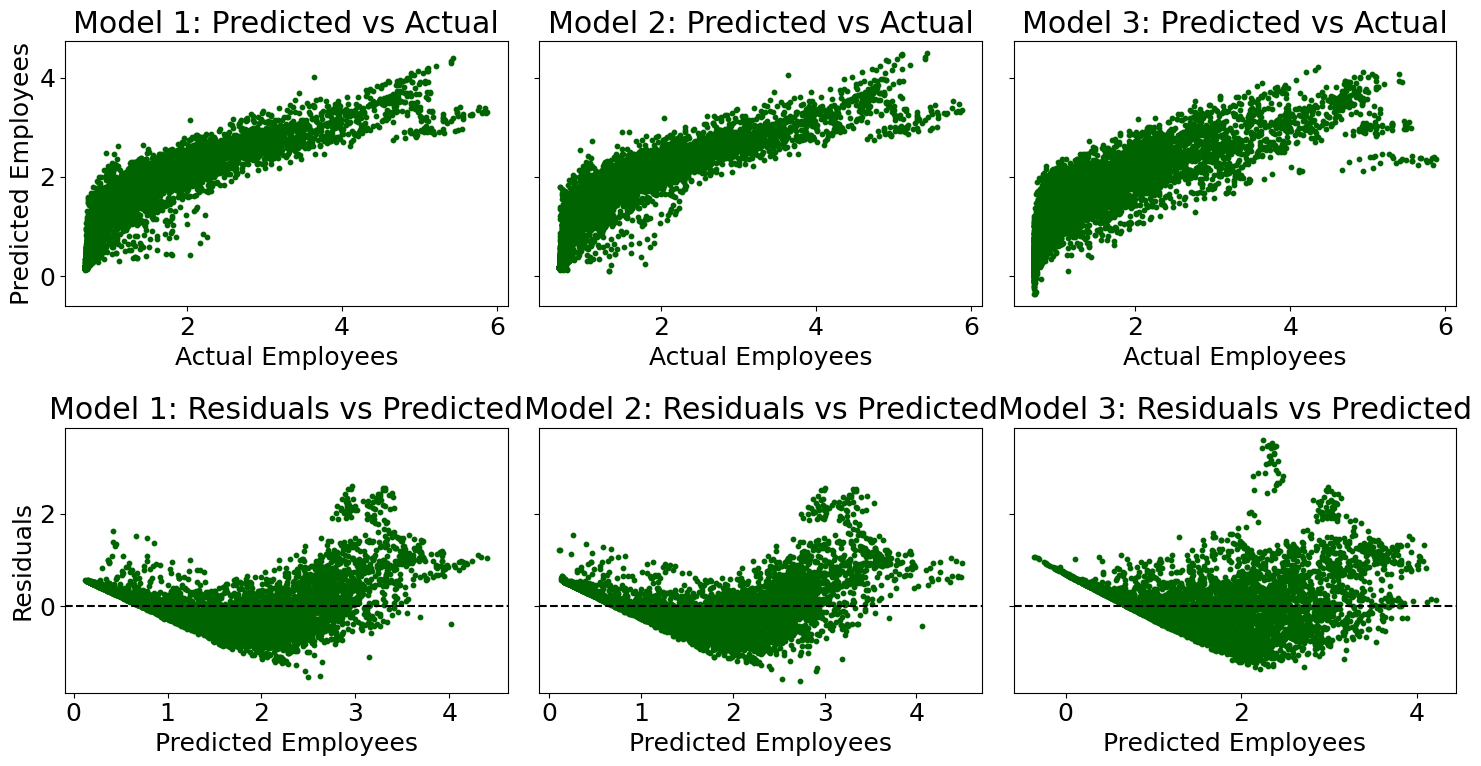

In [86]:
# Get predicted values
y1_predicted = reg1.predict(variables_to_include_reg1)
y2_predicted = reg2.predict(variables_to_include_reg2)
y3_predicted = reg3.predict(variables_to_include_reg3)

residuals1 = annual_data['Employees'] - y1_predicted
residuals2 = annual_data['Employees'] - y2_predicted
residuals3 = annual_data['Employees'] - y3_predicted


fig, axs = plt.subplots(2,3, figsize=(15,8), sharey='row')

axs[0][0].scatter(annual_data['Employees'], y1_predicted, s=10, color='darkgreen')
axs[0][1].scatter(annual_data['Employees'], y2_predicted, s=10, color='darkgreen')
axs[0][2].scatter(annual_data['Employees'], y3_predicted, s=10, color='darkgreen')

axs[0][0].set_title('Model 1: Predicted vs Actual')
axs[0][0].set_ylabel('Predicted Employees')
axs[0][0].set_xlabel('Actual Employees')

axs[0][1].set_title('Model 2: Predicted vs Actual')
axs[0][1].set_xlabel('Actual Employees')

axs[0][2].set_title('Model 3: Predicted vs Actual')
axs[0][2].set_xlabel('Actual Employees')

# Second row: Residuals
axs[1][0].scatter(y1_predicted, residuals1, s=10, color='darkgreen')
axs[1][1].scatter(y2_predicted, residuals2, s=10, color='darkgreen')
axs[1][2].scatter(y3_predicted, residuals3, s=10, color='darkgreen')

for ax in axs[1]:
    ax.axhline(0, color='black', linestyle='--')

axs[1][0].set_title('Model 1: Residuals vs Predicted')
axs[1][0].set_ylabel('Residuals')
axs[1][0].set_xlabel('Predicted Employees')

axs[1][1].set_title('Model 2: Residuals vs Predicted')
axs[1][1].set_xlabel('Predicted Employees')

axs[1][2].set_title('Model 3: Residuals vs Predicted')
axs[1][2].set_xlabel('Predicted Employees')

plt.tight_layout()
plt.show()

In [87]:
reg_dfs = [variables_to_include_reg1, variables_to_include_reg2, variables_to_include_reg3]

variables_to_include_reg1 = variables_to_include_reg1.dropna()
variables_to_include_reg2 = variables_to_include_reg2.dropna()
variables_to_include_reg3 = variables_to_include_reg3.dropna()


In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for any given dataframe of predictors
def compute_vif(df_vars):
    vif = pd.DataFrame()
    vif["Variable"] = df_vars.columns
    vif["VIF"] = [variance_inflation_factor(df_vars.values, i) for i in range(df_vars.shape[1])]
    return vif

# VIF for each regression set
vif_reg1 = compute_vif(variables_to_include_reg1)
vif_reg2 = compute_vif(variables_to_include_reg2)
vif_reg3 = compute_vif(variables_to_include_reg3)

In [89]:
print("VIF - Model 1:\n")
vif_reg1[1:]

VIF - Model 1:



,Variable,VIF
1,Receivables - Trade,8.190469
2,Liabilities and Stockholders Equity - Total,10.857104
3,Stock Compensation Expense,3.256225


In [90]:
print("\nVIF - Model 2:\n")
vif_reg2[1:]


VIF - Model 2:



,Variable,VIF
1,Receivables - Total,15.810357
2,Sales/Turnover (Net),18.273078
3,"Selling, General and Administrative Expenses",7.925448


In [91]:
print("\nVIF - Model 3:\n")
vif_reg3[1:]


VIF - Model 3:



,Variable,VIF
1,Cash,5.755163
2,Inventories - Total,1.717364
3,Common/Ordinary Equity - Total,6.339505


#### **Quantile Forest**

**Task #1: Identify the Columns to Be Used in the Quantile Forest**

In [92]:
quarterly_data = pd.read_excel('Quarterly Financial Data (No Extra Columns).xlsx')


In [93]:
#quarterly_data = quarterly_data_copy
#quarterly_data_copy = quarterly_data.copy()
#quarterly_data

In [94]:
from scipy.stats import skew

for col in quarterly_data.columns:
    if np.issubdtype(quarterly_data[col].dtype, np.number):
        skewness_value = skew(quarterly_data[col], nan_policy='omit')
        if skewness_value > 1:
            # Only apply log1p to non-negative values
            min_val = quarterly_data[col].min()
            if min_val >= 0:
                quarterly_data[col] = np.log1p(quarterly_data[col])

/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1193: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [95]:
cols = []

for column in list(quarterly_data.columns):
    if column in list(annual_data.columns):
        cols.append(column)

In [96]:
from scipy.stats import ks_2samp

ks_2samp_dict = {}

for column in cols:
    statistic, p_value = ks_2samp(quarterly_data[column], annual_data[column])
    ks_2samp_dict[column] = {
        'statistic': statistic,
        'p-value': p_value
    }

# Convert to DataFrame (transpose for readability)
ks_2samp_df = pd.DataFrame(ks_2samp_dict).T  # Transpose so columns become rows

In [97]:
#ks_2samp_df.to_excel('ks_2samp_df.xlsx')

In [98]:
quarterly_data = quarterly_data[highly_correlated_list]
#quarterly_data

In [99]:
cleaner_quarterly = DataCleaner(quarterly_data, variable_of_interest=None)
summary_quarterly = cleaner.summarize_columns()

summary_quarterly.reset_index(inplace=True)
summary_quarterly.rename(columns={'index': 'Variable'}, inplace=True)

summary_quarterly = summary_quarterly.where(summary_quarterly['% Blank Values'] < 0.04).dropna()

In [100]:
variables_to_include_QRF = list(summary_quarterly['Variable'].unique())
variables_to_include_QRF.remove('const')

#### **End of Task #1**

#### **Task 2: Quantile Regression Forest**

In [101]:
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 18})
import sklearn
sklearn.set_config(transform_output="pandas")

In [102]:
dataset = pd.read_excel('Annual Financial Data (No Extra Columns).xlsx')
quarterly_data = pd.read_excel('Quarterly Financial Data (No Extra Columns).xlsx')

In [103]:
cols_to_include_annual = variables_to_include_QRF
cols_to_include_annual.remove('Data Year - Fiscal')
dataset = dataset[cols_to_include_annual]

In [104]:
dataset = dataset.drop(columns={'Accum Other Comp Inc - Unreal G/L Ret Int in Sec Assets',
                                'Preferred ESOP Obligation - Non-Redeemable',
                                'Preferred ESOP Obligation - Redeemable',
                                'Preferred ESOP Obligation - Total'})

dataset = dataset.dropna()

dataset = dataset[dataset["Employees"] != 0]

In [105]:
dataset['Employees'] = np.log1p(dataset['Employees'])

In [106]:
corr = dataset.corr()

In [107]:
# corr.to_excel('corr.xlsx')

In [108]:
dataset = dataset.drop(columns={'Cash', 
                                'Cash and Short-Term Investments'})

In [109]:
# take 24k random samples
dataset = dataset.sample(5_000, replace=True)

X = dataset
X = X.drop(["Employees"], axis=1)
y = dataset["Employees"]

# assert there are no NaN values
assert X.isna().sum().sum() == 0

In [110]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_calib.shape)
print(X_test.shape)

(3200, 70)
(800, 70)
(1000, 70)


In [111]:
coverage_percent = 90 # the "coverage level"
alpha = (100-coverage_percent)/100


In [112]:
n_bins = 20  # or however many you'd like
dataset["bin"] = pd.qcut(dataset["Employees"], q=n_bins, labels=False, duplicates='drop')

In [113]:
dataset.groupby("bin")["Employees"].agg(["count", "min", "max", "median", "skew"])

,count,min,max,median,skew
bin,,,,,
0,254,0.001000,0.021761,0.009950,0.078042
1,248,0.022739,0.047837,0.034401,0.123157
2,255,0.048790,0.079735,0.062035,0.306583
3,244,0.080658,0.114221,0.098034,-0.145030
4,249,0.115113,0.157004,0.130151,0.313706
5,250,0.157858,0.226338,0.184818,0.278101
6,251,0.227136,0.337900,0.282167,-0.052191
7,250,0.338613,0.463734,0.397433,0.094895
8,249,0.467500,0.587787,0.528862,-0.024798


In [114]:
from quantile_forest import RandomForestQuantileRegressor

bin_models = {}
for b in dataset["bin"].unique():
    df_bin = dataset[dataset["bin"] == b]

    if df_bin.empty:
        print(f"Skipping bin {b}: no samples")
        continue

    X_bin = df_bin.drop(columns=["Employees", "bin"])
    y_bin = df_bin["Employees"]

    qrf = RandomForestQuantileRegressor(n_estimators=1000, 
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42)
    qrf.fit(X_bin, y_bin)
    bin_models[b] = qrf

In [115]:
# Recreate bin edges used in training
_, bin_edges = pd.qcut(dataset["Employees"], q=n_bins, retbins=True, duplicates='drop')

# If you have `y_test`, combine it with `X_test`
df_test = X_test.copy()
df_test["Employees"] = y_test.values  # This allows us to bin the test set

# Assign bins based on the same edges
df_test["bin"] = pd.cut(df_test["Employees"], bins=bin_edges, labels=False, include_lowest=True)

In [116]:
all_preds = []

for b in df_test["bin"].dropna().unique():
    df_bin_test = df_test[df_test["bin"] == b].copy()
    X_bin_test = df_bin_test.drop(columns=["Employees", "bin"])

    model = bin_models[b]
    
    y_pred_bounds = model.predict(X_bin_test, quantiles=[alpha/2, 1-alpha/2])
    y_pred_point = model.predict(X_bin_test, quantiles="mean")

    df_bin_test["point prediction"] = y_pred_point
    df_bin_test["lower"] = y_pred_bounds[:, 0]
    df_bin_test["upper"] = y_pred_bounds[:, 1]

    all_preds.append(df_bin_test)

# Combine results
df_all_preds = pd.concat(all_preds).sort_index()

In [117]:
predictions = df_all_preds.iloc[:, -5:]
predictions.rename(columns={'Employees': 'y_true'}, inplace=True)
predictions

,y_true,bin,point prediction,lower,upper
1,0.085260,3,0.091139,0.081580,0.104360
4,0.096219,3,0.094806,0.082501,0.109751
5,0.101654,3,0.095727,0.082501,0.110647
14,2.493205,17,2.521624,2.442347,2.642448
15,2.492627,17,2.522381,2.442347,2.645891
...,...,...,...,...,...
8133,0.079735,2,0.066311,0.050693,0.079735
8136,0.076035,2,0.069914,0.051643,0.078811
8142,0.103459,3,0.101687,0.084341,0.111586
8146,0.040182,1,0.036456,0.024693,0.044973


In [118]:
bin_coverage = {}

for b in df_all_preds["bin"].unique():
    bin_df = df_all_preds[df_all_preds["bin"] == b]
    
    coverage = (
        (bin_df["Employees"] >= bin_df["lower"]) & 
        (bin_df["Employees"] <= bin_df["upper"])
    ).mean()
    
    bin_coverage[b] = round(coverage * 100, 2)

# Print result
print('Prediction Interval Coverage:')
for b in sorted(bin_coverage):
    print(f"Bin {b}: {bin_coverage[b]}%")

Prediction Interval Coverage:
Bin 0: 100.0%
Bin 1: 100.0%
Bin 2: 100.0%
Bin 3: 100.0%
Bin 4: 100.0%
Bin 5: 100.0%
Bin 6: 100.0%
Bin 7: 100.0%
Bin 8: 100.0%
Bin 9: 100.0%
Bin 10: 100.0%
Bin 11: 100.0%
Bin 12: 100.0%
Bin 13: 100.0%
Bin 14: 100.0%
Bin 15: 100.0%
Bin 16: 100.0%
Bin 17: 100.0%
Bin 18: 100.0%
Bin 19: 93.33%


let us now plot the predictions and their corresponding prediction intervals:

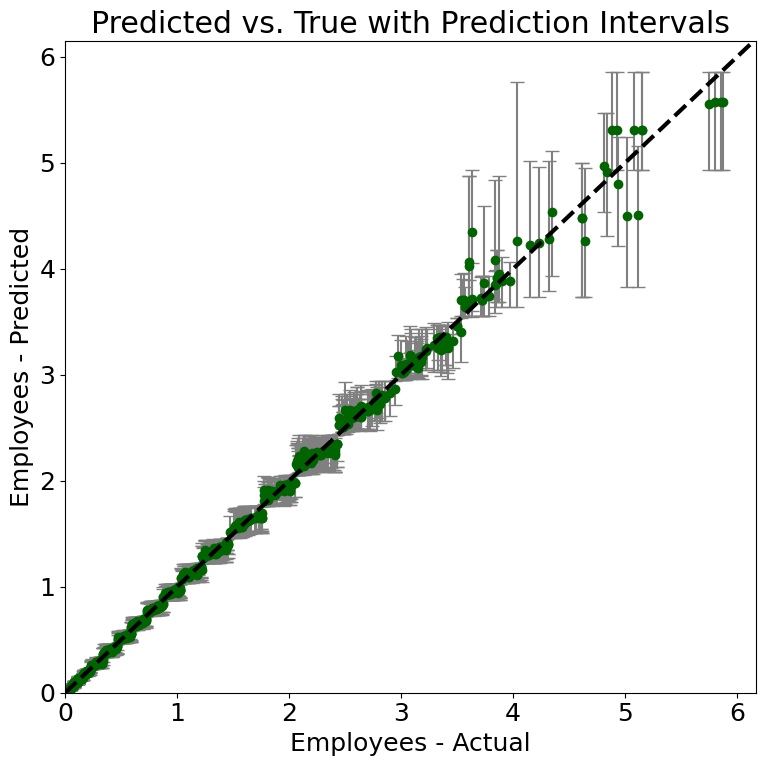

In [122]:
# Compute error bar distances safely
lower_errors = np.maximum(predictions["point prediction"] - predictions["lower"], 0)
upper_errors = np.maximum(predictions["upper"] - predictions["point prediction"], 0)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.errorbar(
    predictions["y_true"], predictions["point prediction"],
    yerr=[lower_errors, upper_errors],
    color='darkgreen', ecolor='grey', linestyle='', marker="o", capsize=5
)

ax.axline([0, 0], [1, 1], color="black", linestyle='--', lw=3, zorder=3)
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Employees - Actual')
plt.ylabel('Employees - Predicted')
plt.title("Predicted vs. True with Prediction Intervals")
plt.tight_layout()
plt.show()

#### Error plot (sorted by prediction interval width)

In [123]:
predictions["error"]   = predictions["point prediction"] - predictions["y_true"]

predictions["error_upper"] =   (predictions["upper"] - predictions["point prediction"])
predictions["error_lower"] =  -(predictions["point prediction"]- predictions["lower"])

# sort by total interval width
predictions["interval_width"] = predictions["upper"] - predictions["lower"]
sorted_predictions = predictions.sort_values(by=['interval_width']).reset_index(drop=True)

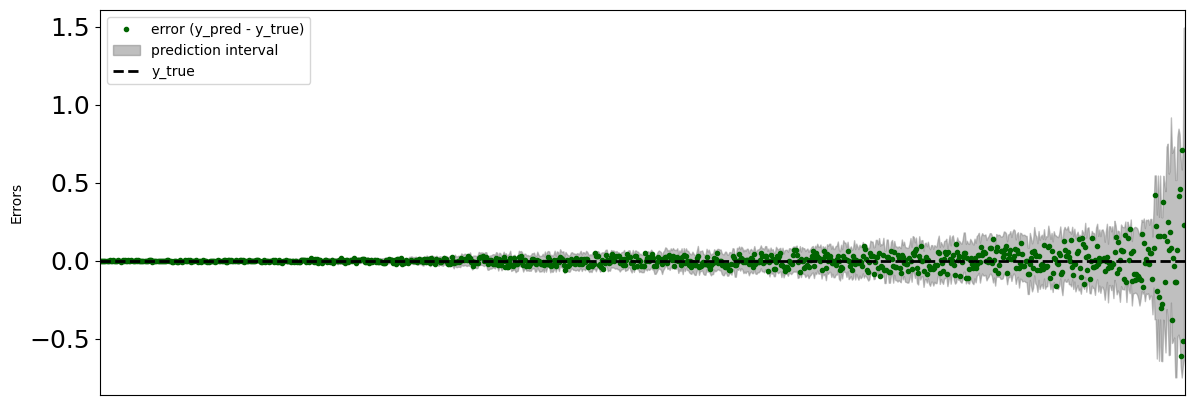

In [124]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(sorted_predictions["error"], 'o', markersize=3, label="error (y_pred - y_true)", color='darkgreen')

plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["error_lower"], 
                 sorted_predictions["error_upper"], 
                 alpha=0.5, color="grey", label="prediction interval")

ax.axline([0, 0], [1, 0], color = "black", linestyle='--', lw=2, zorder=3, label="y_true")
plt.xticks([])
plt.xlim([0, len(sorted_predictions)])
plt.ylabel("Errors", fontsize=10)
plt.legend(loc="upper left", fontsize=10)
plt.show()

Calculate the % of predictions that are within the predicttion interval

In [50]:
# Create an empty dictionary to store coverage results by bin
bin_coverage = {}

# Loop through each bin
for b in sorted_predictions["bin"].unique():
    bin_df = sorted_predictions[sorted_predictions["bin"] == b].copy()
    
    # Check if point is outside the prediction interval
    bin_df["is_outside_range"] = 0
    bin_df["is_outside_range"] = bin_df["is_outside_range"].where(
        (bin_df["error"] < bin_df["error_upper"]) & (bin_df["error"] > bin_df["error_lower"]),
        other=1
    )
    
    # Compute % inside the prediction interval for this bin
    coverage = 100 - (100 / len(bin_df)) * bin_df["is_outside_range"].sum()
    
    # Store result
    bin_coverage[b] = round(coverage, 1)

# Display coverage by bin
for b in sorted(bin_coverage.keys()):
    print(f"Bin {b}: {bin_coverage[b]}% coverage")

Bin 0: 100.0% coverage
Bin 1: 100.0% coverage
Bin 2: 96.5% coverage
Bin 3: 100.0% coverage
Bin 4: 100.0% coverage
Bin 5: 98.1% coverage
Bin 6: 100.0% coverage
Bin 7: 100.0% coverage
Bin 8: 100.0% coverage
Bin 9: 100.0% coverage
Bin 10: 98.0% coverage
Bin 11: 100.0% coverage
Bin 12: 100.0% coverage
Bin 13: 100.0% coverage
Bin 14: 100.0% coverage
Bin 15: 97.9% coverage
Bin 16: 100.0% coverage
Bin 17: 98.3% coverage
Bin 18: 98.2% coverage
Bin 19: 100.0% coverage


Now let us calculate the % of prediction intervals that contained the ground truth value

In [51]:
# count number of prediction intervals that actually contain the ground truth value
sorted_predictions["gt_within_PI"] = 0
sorted_predictions["gt_within_PI"] = sorted_predictions["gt_within_PI"].where((
    (sorted_predictions["y_true"] < sorted_predictions["upper"]) & (sorted_predictions["y_true"] > sorted_predictions["lower"]) ), 
    other=1)

print(round(100-(100/len(sorted_predictions))*sorted_predictions["gt_within_PI"].sum(),1))

91.9


In [52]:
bin_coverage = {}

for b in sorted_predictions["bin"].unique():
    bin_df = sorted_predictions[sorted_predictions["bin"] == b].copy()
    
    bin_df["outside"] = 0
    bin_df["outside"] = bin_df["outside"].where(
        (bin_df["y_true"] < bin_df["upper"]) & (bin_df["y_true"] > bin_df["lower"]),
        other=1
    )
    
    coverage = 100 - (100 / len(bin_df)) * bin_df["outside"].sum()
    bin_coverage[b] = round(coverage, 1)

# Print results
for b in sorted(bin_coverage):
    print(f"Bin {b}: {bin_coverage[b]}% coverage")

Bin 0: 79.2% coverage
Bin 1: 85.1% coverage
Bin 2: 89.5% coverage
Bin 3: 95.2% coverage
Bin 4: 86.7% coverage
Bin 5: 88.9% coverage
Bin 6: 90.7% coverage
Bin 7: 95.3% coverage
Bin 8: 94.1% coverage
Bin 9: 97.6% coverage
Bin 10: 89.8% coverage
Bin 11: 95.3% coverage
Bin 12: 92.9% coverage
Bin 13: 95.0% coverage
Bin 14: 97.8% coverage
Bin 15: 91.5% coverage
Bin 16: 94.1% coverage
Bin 17: 93.2% coverage
Bin 18: 91.2% coverage
Bin 19: 95.7% coverage


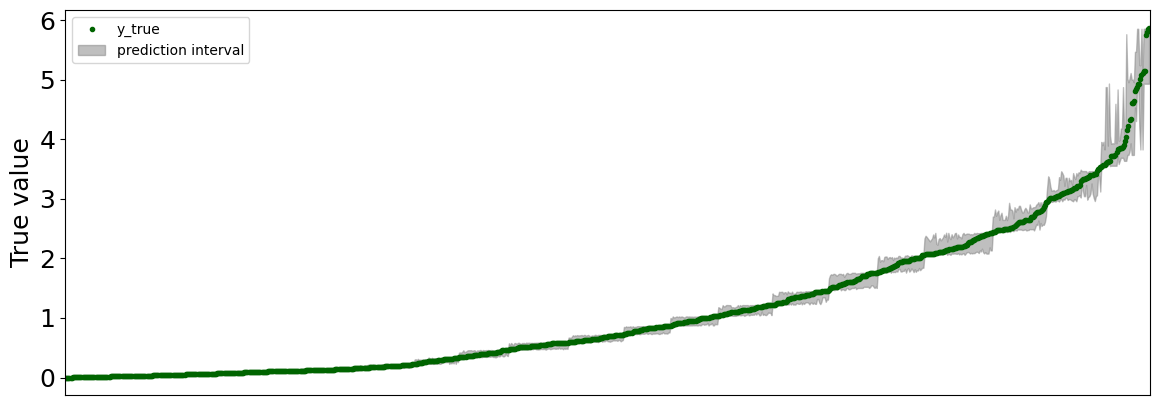

In [125]:
# re-sort for plot
sorted_predictions = predictions.sort_values(by=['y_true']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(sorted_predictions["y_true"], 'o', markersize=3, label="y_true", color='darkgreen')

plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["lower"], 
                 sorted_predictions["upper"], 
                 alpha=0.5, color="grey", label="prediction interval")

plt.xticks([])
plt.xlim([0, len(sorted_predictions)])
plt.ylabel("True value")
plt.legend(loc="upper left", fontsize=10)
plt.show()

Average prediction interval width

In [54]:
print(round(predictions["interval_width"].mean(),-3))
print(round(predictions["interval_width"].median(),-3))

0.0
0.0


In [55]:
predictions["interval_width"] = predictions["upper"] - predictions["lower"]
percentiles = pd.DataFrame(predictions["interval_width"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

percentiles

,interval_width
0.10,0.022170
0.25,0.048033
0.50,0.113791
0.75,0.220133
0.90,0.363015
0.95,0.550672
0.99,1.611870


In [56]:
predictions.dropna(inplace=True)
predictions

,y_true,bin,point prediction,lower,upper,error,error_upper,error_lower,interval_width
18,2.369028,17,2.488536,2.370865,2.672050,0.119508,0.183514,-0.117671,0.301185
19,2.316389,16,2.275297,2.109728,2.351375,-0.041093,0.076079,-0.165568,0.241647
24,2.610070,17,2.621778,2.442347,2.791165,0.011708,0.169387,-0.179431,0.348818
24,2.610070,17,2.621778,2.442347,2.791165,0.011708,0.169387,-0.179431,0.348818
32,0.319907,6,0.320848,0.274597,0.357674,0.000941,0.036827,-0.046251,0.083078
...,...,...,...,...,...,...,...,...,...
8101,5.459815,19,5.225153,4.343723,5.644032,-0.234663,0.418880,-0.881430,1.300310
8115,3.036538,18,3.099011,2.890372,3.430368,0.062473,0.331357,-0.208639,0.539996
8128,2.170767,16,2.157331,2.073549,2.283708,-0.013436,0.126377,-0.083781,0.210159
8132,0.055435,2,0.062092,0.049742,0.080658,0.006657,0.018566,-0.012350,0.030916


In [57]:
#sys.path.append('/kaggle/input/winkler-interval-score-metric/')
import MWIS_metric
# help(MWIS_metric.score)

MWIS,coverage = MWIS_metric.score(predictions["y_true"],predictions["lower"],predictions["upper"],alpha)
print(f"MWI score           ",round(MWIS,3))
print("Predictions coverage    ", round(coverage*100,1),"%")

MWI score            0.19
Predictions coverage     99.6 %


### Conformal prediction
Let us now add *validity* to the prediction intervals using the [conformalized quantile regression (CQR)](https://arxiv.org/pdf/1905.03222.pdf) technique by Emmanuel Candès and co-workers [3].
This is an inductive technique so we shall now make use of the calibration set that we set aside earlier. First we make our predictions for the lower ($l$) and upper ($u$) quantiles in this calibration dataset, just as before


In [58]:
# calculate lower and upper quantile values of the calibration set
y_pred_lower_upper = qrf.predict(X_calib, quantiles=[alpha/2, 1-alpha/2])

calibration_df = pd.DataFrame(y_calib.values, columns = ['y_true'])
calibration_df["lower"] = y_pred_lower_upper[:,0]
calibration_df["upper"] = y_pred_lower_upper[:,1]

we now calculate the *conformity scores* for each row
$$\large E_i := \max \{l_i - y_{true(i)}, y_{true(i)} - u_i \}$$

In [59]:
a  = (calibration_df["lower"]-calibration_df["y_true"]).values
b  = (calibration_df["y_true"]-calibration_df["upper"]).values
calibration_df["Ei"] = (np.vstack((a, b)).T).max(axis=1)

calibration_df

,y_true,lower,upper,Ei
0,0.239017,1.497165,1.750293,1.258148
1,0.916291,1.497165,1.749895,0.580874
2,1.296370,1.499400,1.749895,0.203030
3,0.085260,1.499400,1.740642,1.414140
4,0.833344,1.497165,1.733070,0.663821
...,...,...,...,...
795,0.614645,1.504077,1.733070,0.889432
796,1.117434,1.500069,1.758203,0.382635
797,0.171429,1.499299,1.733070,1.327870
798,0.047837,1.497388,1.738297,1.449551


now we calculate a score $s$ as the following quantile of the $E_i$ values:
$$\large s = \mathrm{quantile} \left( (1-\alpha)(1+1/n) \right) $$
where $n$ is the number of rows in the calibration set

In [60]:
s = calibration_df["Ei"].quantile((1-alpha)*(1+(1/(len(calibration_df)))))
print(s)

1.4873696684598747


then finally we subtract $s$ from the lower quantile we calculated earlier for the test set, and we add $s$ to the upper quantile

In [61]:
predictions["conformal_lower"] = predictions["lower"] - s
predictions["conformal_upper"] = predictions["upper"] + s

predictions

,y_true,bin,point prediction,lower,upper,error,error_upper,error_lower,interval_width,conformal_lower,conformal_upper
18,2.369028,17,2.488536,2.370865,2.672050,0.119508,0.183514,-0.117671,0.301185,0.883495,4.159419
19,2.316389,16,2.275297,2.109728,2.351375,-0.041093,0.076079,-0.165568,0.241647,0.622359,3.838745
24,2.610070,17,2.621778,2.442347,2.791165,0.011708,0.169387,-0.179431,0.348818,0.954977,4.278535
24,2.610070,17,2.621778,2.442347,2.791165,0.011708,0.169387,-0.179431,0.348818,0.954977,4.278535
32,0.319907,6,0.320848,0.274597,0.357674,0.000941,0.036827,-0.046251,0.083078,-1.212773,1.845044
...,...,...,...,...,...,...,...,...,...,...,...
8101,5.459815,19,5.225153,4.343723,5.644032,-0.234663,0.418880,-0.881430,1.300310,2.856353,7.131402
8115,3.036538,18,3.099011,2.890372,3.430368,0.062473,0.331357,-0.208639,0.539996,1.403002,4.917737
8128,2.170767,16,2.157331,2.073549,2.283708,-0.013436,0.126377,-0.083781,0.210159,0.586180,3.771078
8132,0.055435,2,0.062092,0.049742,0.080658,0.006657,0.018566,-0.012350,0.030916,-1.437628,1.568028


now let us take a look at the new coverage

In [62]:
MWIS,coverage = MWIS_metric.score(predictions["y_true"],predictions["conformal_lower"],predictions["conformal_upper"],alpha)
print(f"MWI score           ",round(MWIS,3))
print("Predictions coverage    ", round(coverage*100,1),"%")

MWI score            3.165
Predictions coverage     100.0 %


#### **(Important) Sub-Task: Train QRF Models for Subsets of Quarterly Data to get Predicted Values for Employment**

In [63]:
X_new = quarterly_data[X_train.columns]

In [64]:
# Predict 90% prediction interval (or whatever your original alpha was)
quantiles = [alpha/2, 1 - alpha/2]
pred_new_lower_upper = qrf.predict(X_new, quantiles=quantiles)
pred_new_point = qrf.predict(X_new, quantiles="mean")

In [65]:
# Inflate intervals using conformal score s
pred_new_conformal_lower = pred_new_lower_upper[:, 0] - s
pred_new_conformal_upper = pred_new_lower_upper[:, 1] + s

In [66]:
quarterly_data["Employees_pred_point"] = pred_new_point
quarterly_data["Employees_pred_lower"] = pred_new_conformal_lower
quarterly_data["Employees_pred_upper"] = pred_new_conformal_upper

In [67]:
# Example: build a classifier to distinguish between X_train and X_new
X_combined = pd.concat([X_train, X_new])
y_combined = [0] * len(X_train) + [1] * len(X_new)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
accuracy = cross_val_score(clf, X_combined, y_combined, cv=5).mean()
print("Classifier accuracy:", accuracy)

Classifier accuracy: 0.9982685971488883


In [68]:
quarterly_data = quarterly_data.dropna(subset=['Employees_pred_point'])
quarterly_data = quarterly_data.drop(columns={'Unnamed: 0'})

In [69]:
quarterly_data.to_excel('Quarterly Data (with Employees).xlsx')